<p align="left">
  <a href="https://colab.research.google.com/github/fernandoarcevega/AI_Workshop/blob/main/Part_2/04_MLP_complete/04_MLP_complete_mnl.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200">
  </a>
</p>

In [ ]:
################################################
# Author 1: Wilfrido Gómez-Flores (CINVESTAV)  #
# Author 2: Fernando Arce-Vega (CIO)           #
# e-mail 1: wilfrido.gomez@cinvestav.mx        #
# e-mail 2: farce@cio.mx                       #
# Date:     nov/03/2025                        #
# Subject:  Multi-layer perceptron - complete  #
################################################

In [ ]:
# Libraries
import numpy as np                                                    # Numerical array operations
import pandas as pd                                                   # Data manipulation/analysis
import matplotlib.pyplot as plt                                       # Data plotting/visualization
import os                                                             # Interaction with the operating system
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Model evaluation
from sklearn.model_selection import train_test_split                  # Split data

In [ ]:
# Ignore warnings
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# Load dataset
# Path to dataset
path = 'https://raw.githubusercontent.com/fernandoarcevega/AI_Workshop/main/datasets/mias_data.csv'
T = pd.read_csv(path)
data = T.values
n, d = data.shape
n, d = data.shape
X = data[:, :d-1]                  # Features
Y = np.atleast_2d(data[:, d-1]).T  # Class labels

In [ ]:
# Check feature and targets shapes
print(f'Features shape: {X.shape}')
print(f'Targets shape:  {Y.shape}')

Features shape: (322, 63)
Targets shape:  (322, 1)


In [ ]:
# Split dataset into training and test sets (80%-20%)
Xtr, Xtt, Ytr, Ytt = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Check feature and targets shapes
print(f'Features training shape: {Xtr.shape}')
print(f'Targets training shape:  {Ytr.shape}\n')
print(f'Features testing shape:  {Xtt.shape}')
print(f'Targets testing shape:   {Ytt.shape}')

Features training shape: (257, 63)
Targets training shape:  (257, 1)

Features testing shape:  (65, 63)
Targets testing shape:   (65, 1)


In [ ]:
# Data normalization
def zscorenorm(X, stats=None):

  if stats is None:
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    return (X - mean) / std, (mean, std)

  else:
    mean, std = stats
    return (X - mean) / std

In [ ]:
# MLP trained by SGD
def mlp_train(X, Y, h, eta, l, nb, epochMax, patience, opt):

    # Split into training and validation sets
    X, Xv, Y, Yv = train_test_split(X, Y, test_size=0.2, random_state=42)

    c = int(np.max(Y))
    n, d = X.shape
    tk = (Y == np.arange(1, c + 1)).astype(float)   # Actual outputs in one-hot encoding
    X = np.hstack((np.ones((n, 1)), X))             # Add dummy inputs for the biases calculation
    nv = Xv.shape[0]
    tv = (Yv == np.arange(1, c + 1)).astype(float)  # Actual outputs in one-hot encoding
    Xv = np.hstack((np.ones((nv, 1)), Xv))          # Add dummy inputs for the biases calculation

    # Weights initialization
    rd = lambda a, b, s, t: a + (b - a) * np.random.rand(s, t)        # Xavier initialization
    Wji = rd(-np.sqrt(6 / (d + h)), np.sqrt(6 / (d + h)), h, d + 1)   # Input-hidden layer weights
    Wkj = rd(-np.sqrt(6 / (h + c)), np.sqrt(6 / (h + c)), c, h + 1)   # Hidden-output layer weights

    # Save the current model
    Wjibest = Wji
    Wkjbest = Wkj

    # Moment initialization and parameters
    if opt.lower() in ['momentum', 'adagrad', 'rmsprop']:
        alpha = 0.9                 # Momentum factor
        eps = 1e-8                  # Small value
        Vji = np.zeros((h, d + 1))
        Vkj = np.zeros((c, h + 1))

    elif opt.lower() == 'adam':
        beta1 = 0.9                 # Decay factor 1st moment
        beta2 = 0.999               # Decay factor 2nd moment
        eps = 1e-8                  # Small value
        Vji = np.zeros((h, d + 1))
        Mji = np.zeros((h, d + 1))
        Vkj = np.zeros((c, h + 1))
        Mkj = np.zeros((c, h + 1))

    # Training loop
    B, nbatch = batchify(n, nb)     # Split dataset into mini-batches
    Jt = np.zeros(epochMax)         # Save loss function
    Jv = np.zeros(epochMax)
    for t in range(epochMax):

        Jt[t] = loss(X, tk, Wji, Wkj, l)    # Learning loss
        Jv[t] = loss(Xv, tv, Wji, Wkj, l)   # Validation loss

        # Check early stopping
        if t > patience:
            if Jv[t] < Jv[t - patience]:  # Loss reduces
                Wjibest = Wji             # Save current best
                Wkjbest = Wkj

            else:
                Jt = Jt[:t]               # Cut learning curves to current epoch
                Jv = Jv[:t]
                return Wjibest, Wkjbest, Jt, Jv

        else:
            Wjibest = Wji
            Wkjbest = Wkj

        # Shuffle data every epoch
        X, tk = shuffle(X, tk, n)
        for b in range(1, nbatch + 1):
            idx = (B == b)
            Xb = X[idx, :]
            tb = tk[idx, :]

            # Compute gradients
            Dwji, Dwkj = deltaRules(Xb, tb, Wji, Wkj)

            # Weight updates
            if opt.lower() == 'sgd':
                Wji = (1 - eta * l) * Wji - eta * Dwji  # Input-hidden
                Wkj = (1 - eta * l) * Wkj - eta * Dwkj  # Hidden-output

            elif opt.lower() == 'momentum':
                Vji = alpha * Vji + (1 - alpha) * Dwji
                Wji = (1 - eta * l) * Wji - eta * Vji
                Vkj = alpha * Vkj + (1 - alpha) * Dwkj
                Wkj = (1 - eta * l) * Wkj - eta * Vkj

            elif opt.lower() == 'adagrad':
                Vji += Dwji * Dwji
                Wji = (1 - eta * l) * Wji - (eta / (np.sqrt(Vji) + eps)) * Dwji
                Vkj += Dwkj * Dwkj
                Wkj = (1 - eta * l) * Wkj - (eta / (np.sqrt(Vkj) + eps)) * Dwkj

            elif opt.lower() == 'rmsprop':
                Vji = alpha * Vji + (1 - alpha) * Dwji **2
                Wji = (1 - eta * l) * Wji - (eta / (np.sqrt(Vji) + eps)) * Dwji
                Vkj = alpha * Vkj + (1 - alpha) * Dwkj **2
                Wkj = (1 - eta * l) * Wkj - (eta / (np.sqrt(Vkj) + eps)) * Dwkj

            elif opt.lower() == 'adam':
                Mji = beta1 * Mji + (1 - beta1) * Dwji
                Vji = beta2 * Vji + (1 - beta2) * Dwji **2
                hMij = Mji / (1 - beta1 ** (t + 1))
                hVji = Vji / (1 - beta2 ** (t + 1))
                Wji = (1 - eta * l) * Wji - ((eta * hMij) / (np.sqrt(hVji) + eps))
                Mkj = beta1 * Mkj + (1 - beta1) * Dwkj
                Vkj = beta2 * Vkj + (1 - beta2) * Dwkj **2
                hMkj = Mkj / (1 - beta1 ** (t + 1))
                hVkj = Vkj / (1 - beta2 ** (t + 1))
                Wkj = (1 - eta * l) * Wkj - (eta * hMkj / (np.sqrt(hVkj) + eps))

    return Wjibest, Wkjbest, Jt, Jv

In [ ]:
# Sigmoid function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
# Softmax function
def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [ ]:
# Shuffle data
def shuffle(X, Y, n):
  idx = np.random.permutation(n)
  X = X[idx, :]
  Y = Y[idx, :]
  return X, Y

In [ ]:
# Split dataset into mini-batches
def batchify(n, nb):
  B = np.zeros(n, dtype=int)
  p = 0
  c = 0

  while p < n:
      q = 0
      c += 1

      while p < n and q < nb:
          p += 1
          q += 1
          B[p - 1] = c

  return B, c

In [ ]:
# Compute gradients
def deltaRules(X, tk, Wji, Wkj):

    # Forward
    yj = sigmoid(X @ Wji.T)                         # Hidden layer response
    yj = np.hstack((np.ones((X.shape[0], 1)), yj))  # Add dummy inputs
    zk = softmax(yj @ Wkj.T)                        # Output layer response

    # Backward
    h = Wji.shape[0]
    dk = zk - tk                        # Delta k
    Dwkj = dk.T @ yj                    # Delta rule hidden-output
    dj = (dk @ Wkj) * (yj * (1 - yj))   # Delta j
    Dwji = dj[:, 1:h + 1].T @ X         # Delta rule input-hidden

    return Dwji, Dwkj

In [ ]:
# Compute gradients
def loss(X, tk, Wji, Wkj, l):
    ce = lambda t, z: -np.sum(t * np.log(z + np.finfo(float).eps), axis=1)  # Cross-entropy loss function

    # Forward
    yj = sigmoid(X @ Wji.T)                               # Hidden layer response
    yj = np.hstack((np.ones((X.shape[0], 1)), yj))        # Add dummy inputs
    zk = softmax(yj @ Wkj.T)                              # Output layer response
    L2 = (l / 2) * (np.sum(Wji ** 2) + np.sum(Wkj ** 2))
    Jt = np.mean(ce(tk, zk)) + L2                         # Regularized cross-entropy loss

    return Jt

In [ ]:
# Predict with MLP
def mlp_predict(X, Wji, Wkj):
    unos = np.ones((X.shape[0], 1))
    X = np.hstack((unos, X))                        # Add dummy inputs
    yj = sigmoid(X @ Wji.T)                         # Hidden layer response
    yj = np.hstack((unos, yj))                      # Add dummy inputs
    zk = softmax(yj @ Wkj.T)                        # Output layer response
    ypp = np.argmax(zk, axis=1, keepdims=True) + 1  # Classification by maximum probability

    return ypp, zk

In [ ]:
# Norm data
Xtr, stats = zscorenorm(Xtr)
Xtt = zscorenorm(Xtt, stats)

In [ ]:
# Hyper-parameters
h = 100             # Hidden neurons
epochMax = 10000    # Number of training epochs
eta = 1e-5          # Learning rate
lam = 1e-8          # Regularization factor
nb = 64             # Batch size
patience = 100      # Patience
opt = 'adam'        # Optimizer

In [ ]:
# Train MLP
Wji, Wkj, Jt, Jv = mlp_train(Xtr, Ytr, h, eta, lam, nb, epochMax, patience, opt)

In [ ]:
# Predict test data
Ypp, zk = mlp_predict(Xtt, Wji, Wkj)

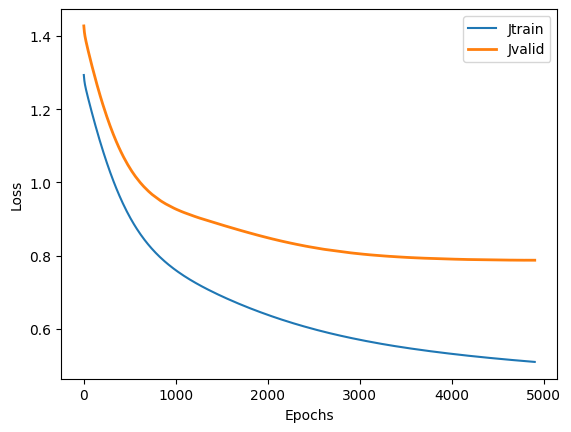

In [ ]:
# Learning curve
plt.figure()
plt.plot(np.arange(1, len(Jt) + 1), Jt, label='Jtrain')
plt.plot(np.arange(1, len(Jv) + 1), Jv, label='Jvalid', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

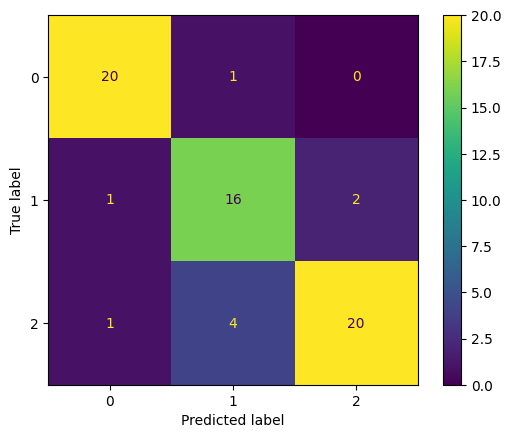

Error: 13.846%


In [ ]:
# Confusion matrix
cm = confusion_matrix(Ytt, Ypp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print classification error
err = np.mean(Ypp != Ytt)
print(f'Error: {100 * err:.3f}%')